# การสำรวจข้อมูล

In [1]:
#นำเข้า library ที่จำเป็น
import music21 # ใช้ในการอ่านโน๊ต และอ่านไฟล์ .midi
import mido # ใช้ในการอ่านไฟล์ .midi ให้เป็น message
import pypianoroll # ใช้ในการดัดแปลง pianoroll array และ บันทึกไฟล์ .midi
from music21 import converter, instrument, note, chord # function และ module ที่จำเป็นในการจัดกระทำข้อมูล

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import os
import os.path as op
from pathlib import Path
import glob
from tqdm import tqdm
import pickle

In [2]:
DATA = "../data"

In [3]:
## เปลี่ยนเชื่อไฟล์ข้อมูลให้ไม่มีช่องว่าง " " โดยการแทนที่ด้วย "_"

for music in glob.glob(DATA+"/undertale/*.mid"):
    music_new_name  = "_".join(music.split(" "))
    os.rename(music, music_new_name)

In [4]:
## get all data resolutions -> ดูว่าโน็ตตัวดำ 1 ตัวถูกแบ่งเป็นกี่โน๊ตย่อย (resolution) -> อาศัยในการแปลง resolution ในอนาคต
resolution_list = []
error_file = [] # ตรวจหาไฟล์ที่ไม่สามารถเปิดได้  aka. เสีย
for music in tqdm(glob.glob(DATA+"/undertale/*.mid")):
    try:
        mid = mido.MidiFile(filename=music, clip=True) # ใช้ library mido ในการอ่าน midi โดยใช้ argument "clip" เพื่อกำหนดค่าให้อยู่ในช่วง 0-127 
        resolution_list.append({Path(music).stem: mid.ticks_per_beat}) # เก็บค่า resolution และ ชื่อเพลง
        
    # ERRORs ที่อาจเกิดขึ้นได้
    except ValueError: 
        error_file.append(music)
        print(f"ValueError: data byte must be in range 0..127 at file {music}")

    except OSError:
        error_file.append(music)
        print(f"OSError: data byte must be in range 0..127 at file {music}")
    
    except EOFError:

        error_file.append(music)
        print(f"EOFError: at file {music}")

100%|██████████| 148/148 [00:06<00:00, 22.58it/s]


In [5]:
# ตรวจสอบผลลัพธ์
print("total error files : ",len(error_file))
print("total successfully loaded : ",len(resolution_list))
print("total files count : ",len(glob.glob(DATA+"/undertale/*.mid")))

total error files :  0
total successfully loaded :  148
total files count :  148


In [6]:
# ดูชื่อไฟล์ที่ไม่สามารถอ่านได้ -> ใช้ในการคัดออกในลำดับถัดไป
error_file

[]

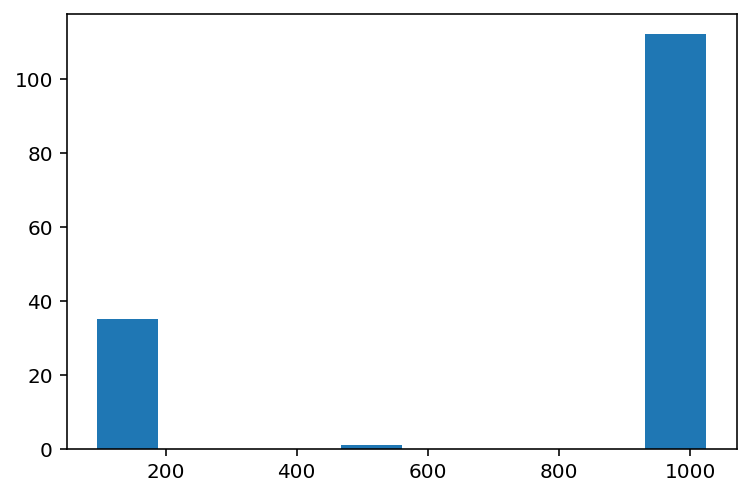

In [7]:
### ดูการกระจายตัวของ resolution ในชุดข้อมูล

plt.hist(np.array([list(res_dict.values())[0] for res_dict in resolution_list]), bins=10)
plt.show()

In [8]:
#### กำหนด function เพื่อแปลง midi (อาจมีหลายเสียงเครื่องดนตรี ["track"] ใน 1 ไฟล์ )ให้เป็น pianoroll ที่ประกอบด้วยเครื่องดนตรีเพียงชนิดเดียว
def midi_2_pianoroll(midifile):
    # อ่านไฟล์
    mid = mido.MidiFile(str(midifile), clip=True)
    # function ใช้ในการเปลี่ยนจาก midi message เป็น dictionary -> จุดเริ่มต้น&สิ้นสุดของโน๊ต + ความดัง
    def msg2dict(msg):
        result = dict()
        if 'note_on' in msg:
            on_ = True
        elif 'note_off' in msg:
            on_ = False
        else:
            on_ = None
        result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
            str.maketrans({a: None for a in string.punctuation})))

        if on_ is not None:
            for k in ['note', 'velocity']:
                result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                    str.maketrans({a: None for a in string.punctuation})))
        return [result, on_]
    
    # function เปลี่่ยนเป็นโน๊ตตัวถัดไปหลังจากจบโน๊ตตัวก่อน : การตรวจจับการเปลี่ยน
    def switch_note(last_state, note, velocity, on_=True):

        result = [0] * 128 if last_state is None else last_state.copy()

        result[note] = velocity if on_ else 0 
        return result
    # function เปลี่่ยนเป็นโน๊ตตัวถัดไปหลังจากจบโน๊ตตัวก่อน : ทำการเปลี่ยน
    def get_new_state(new_msg, last_state):
        new_msg, on_ = msg2dict(str(new_msg))
        new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
        return [new_state, new_msg['time']]
    # function เปลี่ยนจาก message ของ ทุก track ให้เป็น sequence เพียง sequence เดียว ->> *** สำคัญในการแปลงเป็นเสียงเครื่องดนตรีชนิดเดียว ***
    def track2seq(track):
     
        result = []
        last_state, last_time = get_new_state(str(track[0]), [0]*128)
        for i in range(1, len(track)):
            new_state, new_time = get_new_state(track[i], last_state)
            if new_time > 0:
                result += [last_state]*new_time
            last_state, last_time = new_state, new_time
        return result

    ## function แปลง midi เป็น pianoroll สมบูรณ์
    def mid2arry(mid, min_msg_pct=0.1):
        tracks_len = [len(tr) for tr in mid.tracks]
        min_n_msg = max(tracks_len) * min_msg_pct
        # แปลง tracks แต่ละ track ให้เป็น list หลายชั้น
        all_arys = []
        for i in range(len(mid.tracks)):
            if len(mid.tracks[i]) > min_n_msg:
                ary_i = track2seq(mid.tracks[i])
                all_arys.append(ary_i)
        # ทำให้ list หลายชันดังกล่าวมีความยาวเท่ากัน
        max_len = max([len(ary) for ary in all_arys])
        for i in range(len(all_arys)):
            if len(all_arys[i]) < max_len:
                all_arys[i] += [[0] * 128] * (max_len - len(all_arys[i]))
        all_arys = np.array(all_arys)
        all_arys = all_arys.max(axis=0)
        # ตัดช่วงเงียบออก
        sums = all_arys.sum(axis=1)
        ends = np.where(sums > 0)[0]
        return all_arys[min(ends): max(ends)]
    
    result_array = mid2arry(mid)
    
    
    return result_array

# การลด resolution (ความละเอียดของโน๊ตตัวดำ 1 ตัว)

In [9]:
# ทำการลด resolution เหลือ 96 โดยไม่เสียนัยของข้อมูล แต่ทำให้สามารถเปิดได้ง่ายขึ้น และมีความซับซ้อนน้อยลง
## *** การ deresolution สามารถทำเป็นขั้นเดียวกับการลดจำนวน track ได้ -> เขียนรวบเป็นขั้นตอนเดียวกัน ***

In [10]:
# กำหนดค่า resolution ที่ต้องการ 
target_res = 96

In [11]:
# หา tempo ของ midi -> tempo array
def get_tempo(mid):
    tempo_list = []
    for track in mid.tracks:
        for msg in track:
            if msg.type == 'set_tempo':
                tempo_list.append(msg.tempo)
            else:
                tempo_list.append(500000)


    return np.array(tempo_list)

In [12]:
## function แปลงจาก pianoroll เป็น midi เช่นเดิม
def pianoroll_array_2_midi(array: np.array, tempo, resolution):
    return pypianoroll.Multitrack(tracks=[pypianoroll.StandardTrack(name="My Track", pianoroll=array, program=0)], tempo=tempo, resolution=resolution)

In [13]:
# กำหนดโฟลเดอร์ของ midi ที่ทำการแปลง resolution แล้ว
preprocessed_dir = DATA + "/96_res"

In [14]:
##  สร้าง list และ dict ที่เก็บข้อมูลสำคัญต่างๆของ midi

meta_list = []
error_file = []
print("Starts getting data!")
for music in tqdm(glob.glob(DATA+"/undertale/*.mid")):
    music_dict = {}
    try:
        mid = mido.MidiFile(music, clip=True)
        music_dict["old_path"] = music
        music_dict["new_path"] = op.join(preprocessed_dir, Path(music).stem+".mid")
        music_dict["resolution"] = mid.ticks_per_beat
        music_dict["old_tempo"] = mido.tempo2bpm(get_tempo(mid))
        music_dict["new_tempo"] = music_dict["old_tempo"] / (target_res/music_dict["resolution"]) # เมื่อทำการลด resolution เพื่อทำให้ความเร็วของเพลงเหมือนเดิม -> เพิ่ม tempo ในอัตราส่วนเดียวกัน
        music_dict["pianoroll_array"] = midi_2_pianoroll(music_dict["old_path"])
        
        
        meta_list.append(music_dict)
    except ValueError:
        error_file.append(music)
        print(f"ValueError: data byte must be in range 0..127 at file {music}")

    except OSError:
        error_file.append(music)
        print(f"OSError: data byte must be in range 0..127 at file {music}")
    
    except EOFError:

        error_file.append(music)
        print(f"EOFError: at file {music}")

Starts getting data!


100%|██████████| 148/148 [06:48<00:00,  2.76s/it]


In [16]:
## เริ่มทำการ preprocess
### หากต้องการเพิ่ม handle exception สามารถ uncomment ได้
print("Start writing preprocessed data!")
for music_dict in tqdm(meta_list):
    #try:
        midi_tracks = pianoroll_array_2_midi(music_dict["pianoroll_array"], music_dict["new_tempo"], target_res)
        # เขียน midi
        pypianoroll.write(music_dict["new_path"], midi_tracks)
    #except:
        #print(f"There is an error at {music_dict['new_path']}")

Start writing preprocessed data!


100%|██████████| 148/148 [01:06<00:00,  2.21it/s]


# การเตรียมข้อมูลสำหรับโมเดลประเภท window sliding

In [17]:
### ภายหลังจาการ deresolution เราจะทำการแปลง midi ให้เป็นลำดับของโน๊ต

In [18]:
# รวมลำดับโน็ต
notes = []

for file in tqdm(glob.glob(preprocessed_dir + "/*.mid")):
    midi = converter.parse(file)
    notes_to_parse = None
    # อ่านโน๊ตแบบ flat note
    notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
        if isinstance(element, note.Note): 
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord): # แปลง chord ให้กลายเป้น string ของตัวเลข ที่ระบุโน๊ตแต่ละตัว เช่น "1.6.7.11"
            notes.append('.'.join(str(n) for n in element.normalOrder))

100%|██████████| 148/148 [8:28:07<00:00, 206.00s/it]    


In [19]:
# บันทึกลำดับโน๊เพื่อใช้ในการ train ต่อไป
with open('../data/notes_final.pkl', 'wb') as f:
    pickle.dump(notes, f)

In [20]:
## จะทำการ window sliding ใน file ที่ทำการ train โมเดล

# การเตรียมข้อมูลสำหรับโมเดลประเภท Teacher Forcing

In [21]:
# เก็บข้อมูลของชื่อเพลง และลำดับโน๊ตเป็น dictionary
dataset = dict()

for file in tqdm(glob.glob(preprocessed_dir + "/*.mid")):
    notes = []
    midi = converter.parse(file)
    notes_to_parse = None
    
    notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))
    
    dataset[str(file)] = notes

        #keys    # values
### {"ชื่อเพลง" : [notes],  ...}

100%|██████████| 148/148 [01:09<00:00,  2.13it/s]


In [22]:
# บันทึก dictionary
with open('../data/dataset_undertale_dict.pkl', 'wb') as f:
    pickle.dump(dataset, f)


# การตรวจสอบข้อมูลหลังทำความสะอาด

In [23]:
### plot sequence length

seq_list = []
path_list = []
length_list = []
for key, value in dataset.items():
    seq_list.append(value)
    path_list.append(key)
    length_list.append(len(value))



df = pd.DataFrame({"Path" : path_list, "Seq" : seq_list, "Length" : length_list})

df

,Path,Seq,Length
0,../data/96_res\006_Uwa!!_So_Temperate.mid,"[G#3, G6, G#3, G6, G#3, G6, C4, F6, C4, F6, C4...",2083
1,../data/96_res\007_Anticipation.mid,"[6.7.9.11, G2, 6.7.11, G2, 6.7.11, G2, 6.7.11,...",145
2,../data/96_res\008_Unnecessary_Tension.mid,"[1.2, 1.6, 1.2.6, 1, 1.6, 1.7, 1, 1, 6.9.1, 1,...",86
3,../data/96_res\018_Uwa!!_So_Holiday.mid,"[9.1.2, 5.9, 5.9, 5.9, 5.9, C5, 5.9, 5.9, 5, 9...",218
4,../data/96_res\025_Dating_Start!.mid,"[10.11.0.1.3, 3.5.7.10, 11.0.2.4.6.8, 3.5.7.10...",783
...,...,...,...
143,../data/96_res\Undertale_-_Waterfall.mid,"[E5, E5, B5, B5, F#6, F#6, D6, D6, E6, E6, B5,...",1948
144,../data/96_res\Undertale_-_Wrong_Enemy.mid,"[A2, A2, 4.9, 4.9, 8.9, 4.9, 11.4, 11.4, 1.4.7...",1784
145,../data/96_res\Undertale_-_Your_Best_Friend.mid,"[G#4, G#4, C5, C5, E-4, E-4, C5, C5, G#4, G#4,...",308
146,../data/96_res\Undertale_-_Your_Best_Nightmare...,"[4.5.10, 4.5.10, 4.5.10, 4.5.10, 4.5.10, 4.5.1...",4146


<AxesSubplot:xlabel='Length'>

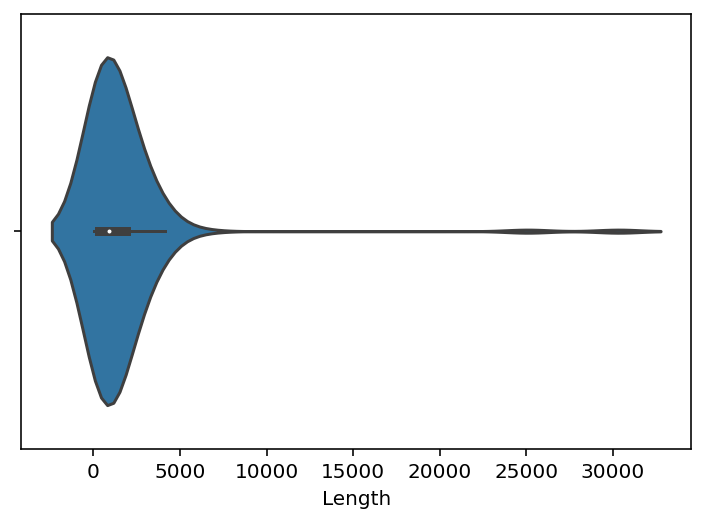

In [24]:
sns.violinplot(data=df, x="Length")

1140


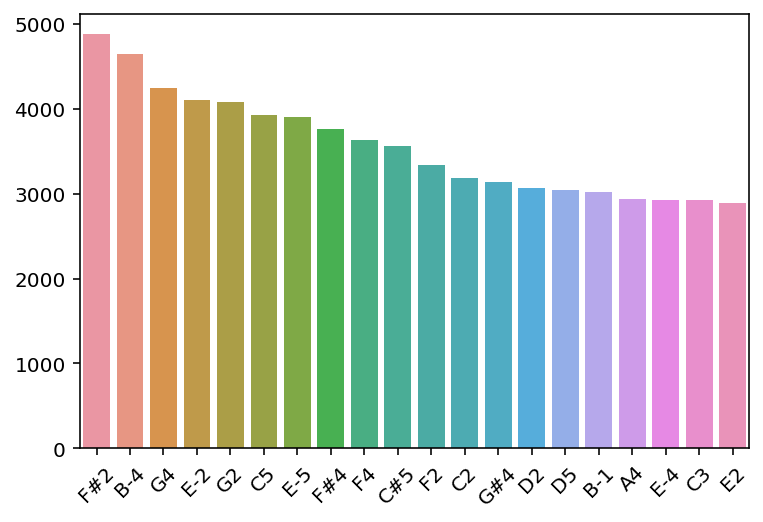

In [25]:
## get note frequencies

notes = []
for indx, (path, seq, length) in df.iterrows():
    notes.extend(seq)

unique_notes = set(notes)

print(len(unique_notes))

### counter

count_notes = dict()

for note in notes:

    if note in count_notes.keys():

        count_notes[note] += 1

    else:

        count_notes[note] = 1

sorted_count = {k : v for k, v in sorted(count_notes.items(), key = lambda x: x[1], reverse=True)}


g = sns.barplot(x=list(sorted_count.keys())[:20], y=list(sorted_count.values())[:20])
plt.xticks(rotation=45)
plt.show()

In [26]:
df.describe()

# -> min length is 14 -> window_size = 14
# เลือกความยาวของ sequence มาตรฐานตามความยาวของข้อมูลที่สั่นที่สุดที่ยังเป็นเพลง (ในที่นี้คือความยาว 14 โน๊ต)

,Length
count,148.000000
mean,1588.574324
std,3281.313079
min,14.000000
25%,312.500000
50%,913.500000
75%,1871.500000
max,30339.000000


# การเตรียมข้อมูลสำหรับโมเดลประเภท Teacher Forcing (ต่อ)

In [27]:
df["num_windows"] = df["Length"].apply(lambda x: x // 14)
df["last_note"] = df["Length"].apply(lambda x: 14 * (x // 14))
df["indx"] = df["Length"].apply(lambda x: 14 * np.arange((x // 14) + 1))
df["indx_"] = df["indx"].apply(lambda x: np.lib.stride_tricks.sliding_window_view(x, 2))

In [28]:
df["indx_"] # ลำดับของตัวโน๊ตที่ต้องตัด

0      [[0, 14], [14, 28], [28, 42], [42, 56], [56, 7...
1      [[0, 14], [14, 28], [28, 42], [42, 56], [56, 7...
2      [[0, 14], [14, 28], [28, 42], [42, 56], [56, 7...
3      [[0, 14], [14, 28], [28, 42], [42, 56], [56, 7...
4      [[0, 14], [14, 28], [28, 42], [42, 56], [56, 7...
                             ...                        
143    [[0, 14], [14, 28], [28, 42], [42, 56], [56, 7...
144    [[0, 14], [14, 28], [28, 42], [42, 56], [56, 7...
145    [[0, 14], [14, 28], [28, 42], [42, 56], [56, 7...
146    [[0, 14], [14, 28], [28, 42], [42, 56], [56, 7...
147    [[0, 14], [14, 28], [28, 42], [42, 56], [56, 7...
Name: indx_, Length: 148, dtype: object

In [29]:
df[["num_windows"]].describe() # ตรวจสอบว่า min เป็น 1

,num_windows
count,148.00000
mean,113.02027
std,234.37163
min,1.00000
25%,22.00000
50%,64.50000
75%,133.25000
max,2167.00000


In [30]:
# function ตัด sequence จากคู่ของ index
def slice_seq(seq, indx):
    sliced = []
    for index in list(indx):
        sliced.append(seq[index[0]: index[1]])

    return sliced

In [31]:
# function ที่จะ apply กับ DataFrame ตามแถว
def indxwise_slice(row):

    return slice_seq(row["Seq"], row["indx_"])

In [32]:
# apply function ตามแถว
df["Data"] = df.apply(lambda row : indxwise_slice(row), axis=1)

In [33]:
df_output = df[["Path", "Data"]]
df_output.to_pickle("../data/dataset_undertale_preprocessed.pkl")

In [34]:
# เก็บ dataset สำรองไว้เป็น list ใน pickle
all_data = []

for indx, seq in zip(list(df["indx_"]), list(df["Seq"])):
    for index in list(indx):
        all_data.append(seq[index[0]: index[1]])


    all_data.append

In [35]:
with open("../data/all_undertale_unique_notes.pkl", "wb") as f:

    pickle.dump(list(unique_notes), f)

In [36]:
with open("../data/all_undertale_teacher_forcing_notes.pkl", "wb") as f:

    pickle.dump(list(all_data), f)

# เรามาลองฟังเพลงจาก note sequence กันเถอะ!

In [ ]:
### utils function that writes .midi files

def create_midi(prediction_output, filename):
    from music21 import note, chord, instrument, stream
    offset = 0
    output_notes = []

        # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
            # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

            # increase offset each iteration so that notes do not stack
        offset += 0.25

    midi_stream = stream.Stream(output_notes)

    midi_stream.write("midi", fp=filename)
    return midi_stream

In [ ]:
import random
for i, q in enumerate(random.choices(range(len(all_data) - 37), k=10)):
    midi_stream = create_midi(np.concatenate([np.array(seq) for seq in all_data[q:q+37]], axis=-1), f"ground_truth_{i+1}.mid")